In [261]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from colorama import Fore, Back, Style
from math import sin, cos, sqrt, atan2
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', -1)

#from sklearn import 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

/var/folders/9q/hm47ykws5rqczggr_dwcfydw0000gn/T/ipykernel_1148/2444926286.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


# Constantes

In [201]:
path = os.getcwd()
path_docs = "/Users/agathe/Downloads/"
#liste des lieux emblématiques de Berlin [nom,lat,long]
centres_berlins = [["charlottenburg", 52.516602, 13.304105],
                   ["kreuzberg", 52.498605, 13.391799],
                   ["wedding", 52.561559, 13.35002],
                   ["mitte", 52.531677, 13.381777],
                   ["mariendorf", 52.4333316, 13.3833318],
                   ["tegel", 52.558833, 13.288437], 
                   ["tempelhof", 52.472160, 13.370287],
                   ["spandau", 52.534080, 13.181716],
                   ["schöneberg", 52.497161, 13.346865],
                   ["wilmersdorf",  52.48333, 13.31667],
                   ["biesdorf", 52.508429, 13.563317],
                   ["moabit", 52.530832, 13.345876],
                   ["britz", 52.45, 13.433333],
                   ["neukölln", 52.440771, 13.444507],
                   ["dahlem", 52.466562, 13.300082], 
                   ["tiergarten", 52.51449, 13.350091],
                   ["hellersdorf", 52.536107, 13.604973],
                   ["prenzlauer_berg", 52.550113, 13.423125], 
                   ["friedrichshain", 52.515816, 13.454293],
                   ["reinickendorf", 52.566667, 13.333333],
                   ["friedrichsfelde", 52.503664652, 13.507664636],
                   ["friedenau", 52.47133, 13.32813],
                   ["gesundbrunnen", 52.548611, 13.390278],
                   ["charlottenbourg_nord", 52.53048, 13.29371],
                   ["hansaviertel", 52.5166646, 13.33666532],
                   ["haselhorst", 52.54409, 13.23743],
                   ["gropiusstadt", 52.425, 13.46667],
                   ["westend", 52.5166646, 13.2833322],
                   ["wittenau", 52.592455, 13.329694],
                   ["zehlendorf", 52.435077, 13.260425],
                   ["lichtenberg", 52.534306, 13.502326],
                   ["pankow", 52.592879, 13.431700],
                   ["steglitz", 52.453096, 13.331171],
                   ["siemenstadt", 52.537664516, 13.257832302],
                   ["rudow", 52.402310, 13.509220],
                   ["kaulsdorf", 52.506512, 13.593946]]

# Fonctions utiles

In [202]:
def distance(lat1,lon1,lat2,lon2):
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def KNN(listings,neighbors,on=['postal_code','',''],how='weighted_average'):
    for i,row in listings.iterrows():
        candidates=neighbors[on+['latitude','longitude','price']].copy()
        for i in range(0,len(on)):
            candidates=candidates[candidates[on[i]]==row[on[i]]]
            
def missing(df,detail=False):
    total = 0
    for col in df.columns:
        miss = df[col].isnull().sum()
        pct = df[col].isna().mean() * 100
        total += miss
        if miss != 0:
            if pct>10: color=Fore.RED
            else: color=Fore.YELLOW
            print(color+'{} => {} [{}%]'.format(col, miss, round(pct, 2)))
        
        elif (total == 0) and(detail):
            print(Fore.GREEN+'{} => no missing values [{}%]'.format(col, 0))
        total=0
        
def drop_virgule(x):
    try:return x.split('.')[0]
    except:return x
    
def add_distance_feature(df, lieu):
    name_column = "distance_" + str(lieu[0])
    df[name_column] = df.apply(lambda x : distance(x['latitude'], x['longitude'], lieu[1], lieu[2]), axis = 1)
    return df

# Importing Data

In [203]:
train_set = pd.read_csv(path + "/train_airbnb_berlin.csv", sep = ",")
test_set = pd.read_csv(path + "/test_airbnb_berlin.csv", sep = ",")

# Data Preprocess and exploring

In [204]:
columns_to_drop=['Listing Name','Host Name','City','Country Code','Country']
types={'Listing ID':'str','Host ID':'str','Postal Code':'str'}

def processing(df):
    df.drop(columns=columns_to_drop,inplace=True) #specified irrelevant columns 
    df.dropna(subset=['Price'], inplace=True)    #drop price missing (9rows)
    
    df['Listing ID']=df['Listing ID'].apply(drop_virgule)              # Drop the '.0' in IDs and Postal Code
    df['Host ID']=df['Host ID'].apply(drop_virgule)
    df['Postal Code']=df['Postal Code'].apply(drop_virgule)
    
    df['Host Since']=pd.to_datetime(df['Host Since'])                  # Convert values to datetime
    df['First Review']=pd.to_datetime(df['First Review'])
    df['Last Review']=pd.to_datetime(df['Last Review'])
    
    df['Accomodates'].replace('*', np.nan,inplace=True)                 # Put NaN in missing values where we have *
    df['Bathrooms'].replace('*', np.nan,inplace=True)
    df['Bedrooms'].replace('*', np.nan,inplace=True)
    df['Beds'].replace('*', np.nan,inplace=True)
    df['Guests Included'].replace('*', np.nan,inplace=True)
    df['Min Nights'].replace('*', np.nan,inplace=True)
    df['Postal Code'].replace('*', np.nan,inplace=True)
    df['neighbourhood'].replace('*', np.nan,inplace=True)
    df['Property Type'].replace('*', np.nan,inplace=True)
    df['Host Response Rate'].replace('*', np.nan,inplace=True)

    #from 98% to 0.98
    df['Host Response Rate'].replace('nan', np.nan,inplace=True)
    df['Host Response Rate']=df[~df['Host Response Rate'].isnull()]["Host Response Rate"].str.split('%').apply(lambda x:float(x[0])/100)

    df['Accomodates'] = df['Accomodates'].astype('float')              # Convert values to float
    df['Bathrooms'] = df['Bathrooms'].astype('float')
    df['Bedrooms'] = df['Bedrooms'].astype('float')
    df['Beds'] = df['Beds'].astype('float')
    df['Guests Included'] = df['Guests Included'].astype('float')
    df['Min Nights'] = df['Min Nights'].astype('float') 
    
    df.columns = df.columns.str.lower().str.replace(' ','_')           # Rename the columns with '_' instead of ' '
    
    for lieu in centres_berlins:                                       # Add distances 
        df = add_distance_feature(df, lieu)

    return df

def processing_2(df):
    
    numerical_columns = df.select_dtypes(include=float).columns   # numeric columns names
    categorical_columns = df.select_dtypes(include=object).columns # categorical columns names
    date_columns = df.select_dtypes(include=np.datetime64).columns # date columns names
    
    df_cleaned_num = df[numerical_columns]    # dataframe with numeric columns only
    df_cleaned_cat = df[categorical_columns]  # dataframe with categorical columns only
    df_cleaned_date = df[date_columns]  # dataframe with date columns only
    
    #standardisation for numeric columns
    scalerx = StandardScaler() 
    df_scaled=pd.DataFrame(scalerx.fit_transform(df_cleaned_num), columns = numerical_columns)
    
    #one encoder for categorical columns
    df_encoded=pd.DataFrame() 
    for cat in categorical_columns:
        df_temp = pd.get_dummies(df_cleaned_cat[cat], prefix=cat)
        df_encoded=pd.concat([df_temp, df_encoded], axis=1)
    
    #concatenation of numeric and categorical dataframes
    df_scaled.reset_index(drop=True, inplace=True)
    df_encoded.reset_index(drop=True, inplace=True)
    df_final=pd.concat([df_scaled, df_encoded], axis=1) 
    df_final=pd.concat([df_final, df_cleaned_date], axis=1)
    
    return df_final 

In [205]:
my_sep,my_encoding=',','utf-8'
columns_to_drop=['Listing Name','Host Name','City','Country Code','Country']
types={'Listing ID':'str','Host ID':'str','Postal Code':'str'}

df=processing(train_set)

# Visualisation

<AxesSubplot:>

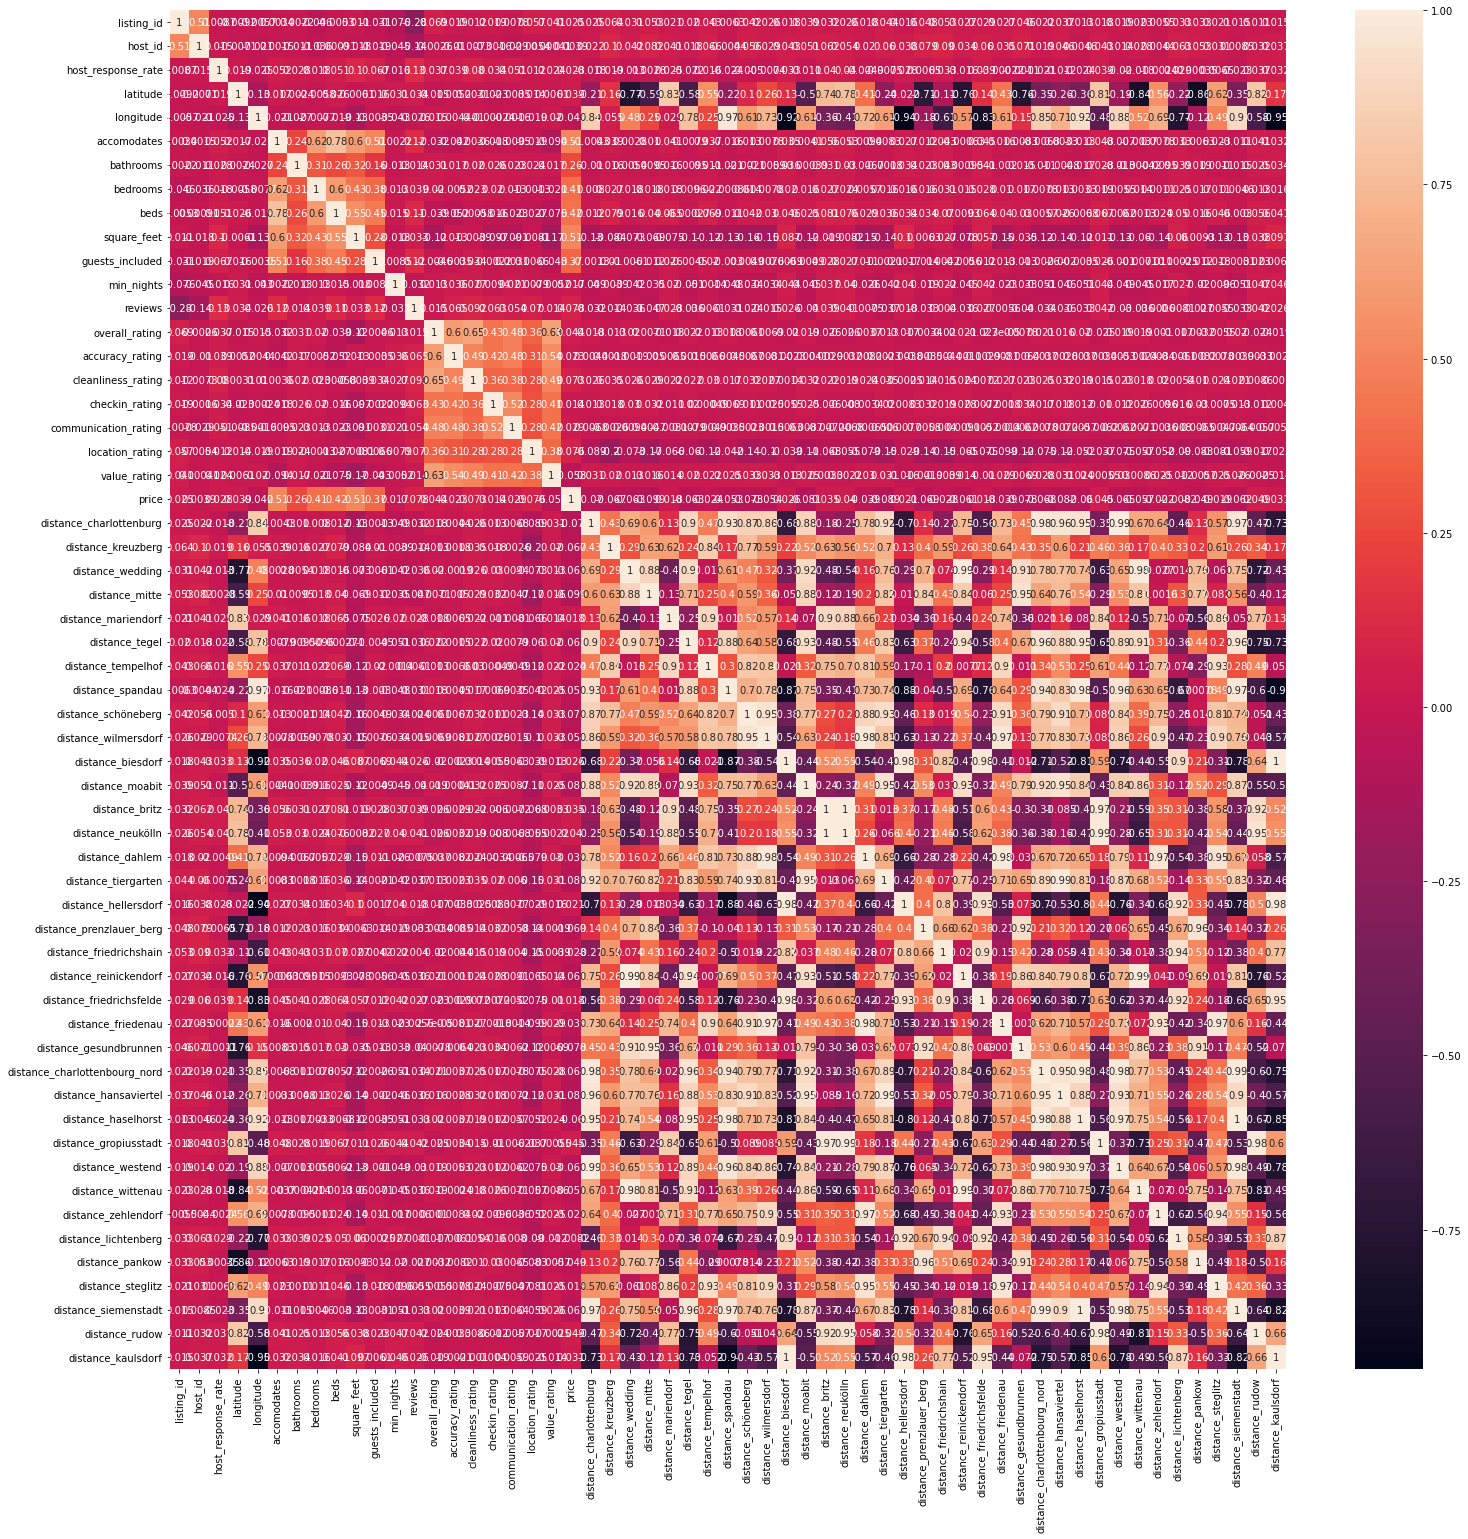

In [206]:
corrMatrices = df.corr()
plt.figure(figsize = (25,25))
sns.heatmap(corrMatrices, annot=True)

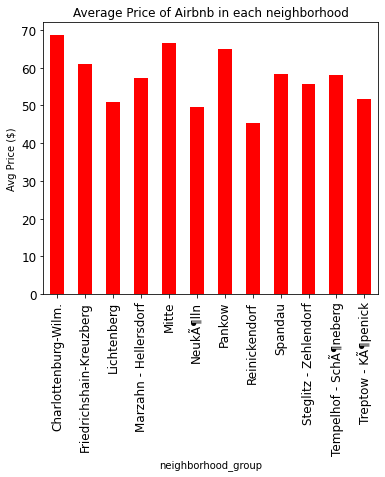

In [207]:
# Plotting the average price neighborhood_group
avg_price_roomtype= df.groupby(['neighborhood_group'])['price'].agg(np.mean)
avg_price_roomtype.plot(kind='bar', color='red', figsize = (6,5), fontsize = 12)
plt.title('Average Price of Airbnb in each neighborhood')
plt.xlabel('neighborhood_group')
plt.ylabel('Avg Price ($)')
plt.show()

In [208]:
#for lieu in centres_berlins : 
#    name = 'distance_' + str(lieu[0])
#    plt.bar(df[name], df['price'])
#    plt.ylabel('prix')
#    plt.xlabel(name)
#    plt.show()

In [209]:
df.corr()['price'].sort_values(ascending = False)

price                            1.000000
square_feet                      0.508934
accomodates                      0.505274
beds                             0.420790
bedrooms                         0.411974
guests_included                  0.367821
bathrooms                        0.257354
reviews                          0.078231
location_rating                  0.076058
cleanliness_rating               0.072634
distance_rudow                   0.049359
distance_gropiusstadt            0.044990
overall_rating                   0.043537
distance_neukölln                0.039610
latitude                         0.039158
distance_britz                   0.034578
distance_kaulsdorf               0.030574
communication_rating             0.028882
host_response_rate               0.027569
distance_biesdorf                0.026262
listing_id                       0.025092
accuracy_rating                  0.022770
distance_hellersdorf             0.021231
distance_mariendorf              0

# Outliers, missing values and scaling

In [210]:
# supprimer les outliers de prix > 300
df = df[df["price"]<300]

#droping rows where there is more than 3 nan 
#from dataviz we saw that it was the best option
df=df[df.isnull().sum(1)<4]

df=processing_2(df)

In [234]:
df_float = df[df.select_dtypes(exclude=np.datetime64).columns]
df_date = df[df.select_dtypes(include=np.datetime64).columns]

### KNN Imputer

In [240]:
imputer = KNNImputer(n_neighbors=5)
df_KNN_Imputer = pd.DataFrame(imputer.fit_transform(df_float),columns = df_float.columns)
df_KNN_Imputer = pd.concat([df_KNN_Imputer, df_date], axis = 1)

### Univariate feature imputation

In [256]:
imp_mean = SimpleImputer(strategy='mean')
df_mean_Imputer = pd.DataFrame(imp_mean.fit_transform(df_float),columns = df_float.columns)
df_mean_Imputer = pd.concat([df_mean_Imputer, df_date], axis = 1)

imp_median = SimpleImputer(strategy='median')
df_median_Imputer = pd.DataFrame(imp_median.fit_transform(df_float),columns = df_float.columns)
df_median_Imputer = pd.concat([df_median_Imputer, df_date], axis = 1)

imp_most_frequent = SimpleImputer(strategy='most_frequent')
df_most_freq_Imputer = pd.DataFrame(imp_most_frequent.fit_transform(df_float),columns = df_float.columns)
df_most_freq_Imputer = pd.concat([df_most_freq_Imputer, df_date], axis = 1)

### Multivariate feature imputation

In [266]:
#regression imputation
it_imp = IterativeImputer()
df_it_imp = pd.DataFrame(it_imp.fit_transform(df_float),columns = df_float.columns)
df_it_Imputer = pd.concat([df_it_imp, df_date], axis = 1)

/Users/agathe/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [270]:
df_it_Imputer.describe()

,listing_id,host_id,host_response_rate,latitude,longitude,accomodates,bathrooms,bedrooms,beds,square_feet,guests_included,min_nights,overall_rating,accuracy_rating,cleanliness_rating,checkin_rating,communication_rating,location_rating,value_rating,price,distance_charlottenburg,distance_kreuzberg,distance_wedding,distance_mitte,distance_mariendorf,distance_tegel,distance_tempelhof,distance_spandau,distance_schöneberg,distance_wilmersdorf,distance_biesdorf,distance_moabit,distance_britz,distance_neukölln,distance_dahlem,distance_tiergarten,distance_hellersdorf,distance_prenzlauer_berg,distance_friedrichshain,distance_reinickendorf,distance_friedrichsfelde,distance_friedenau,distance_gesundbrunnen,distance_charlottenbourg_nord,distance_hansaviertel,distance_haselhorst,distance_gropiusstadt,distance_westend,distance_wittenau,distance_zehlendorf,distance_lichtenberg,distance_pankow,distance_steglitz,distance_siemenstadt,distance_rudow,distance_kaulsdorf,business_travel_ready_f,instant_bookable_f,instant_bookable_t,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,property_type_Apartment,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Condominium,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Loft,property_type_Other,property_type_Serviced apartment,property_type_Townhouse,is_exact_location_f,is_exact_location_t,postal_code_10115,postal_code_10117,postal_code_10119,postal_code_10178,postal_code_10179,postal_code_10243,postal_code_10245,postal_code_10247,postal_code_10249,postal_code_10315,postal_code_10317,postal_code_10318,postal_code_10319,postal_code_10365,postal_code_10367,postal_code_10369,postal_code_10405,postal_code_10407,postal_code_10409,postal_code_10435,postal_code_10437,postal_code_10439,postal_code_10551,postal_code_10553,postal_code_10555,postal_code_10557,postal_code_10559,postal_code_10585,postal_code_10587,postal_code_10589,postal_code_10623,postal_code_10625,postal_code_10627,postal_code_10629,postal_code_10707,postal_code_10709,postal_code_10711,postal_code_10713,postal_code_10715,postal_code_10717,postal_code_10719,postal_code_10777,postal_code_10779,postal_code_10781,postal_code_10783,postal_code_10785,postal_code_10787,postal_code_10789,postal_code_10823,postal_code_10825,postal_code_10827,postal_code_10829,postal_code_10961,postal_code_10963,postal_code_10965,postal_code_10967,postal_code_10969,postal_code_10997,postal_code_10999,postal_code_12043,postal_code_12045,postal_code_12047,postal_code_12049,postal_code_12051,postal_code_12053,postal_code_12055,postal_code_12057,postal_code_12059,postal_code_12099,postal_code_12101,postal_code_12103,postal_code_12105,postal_code_12157,postal_code_12159,postal_code_12161,postal_code_12163,postal_code_12167,postal_code_12203,postal_code_12347,postal_code_12435,postal_code_12437,postal_code_12459,postal_code_12489,postal_code_12527,postal_code_12555,postal_code_12587,postal_code_12589,postal_code_12623,postal_code_12683,postal_code_13055,postal_code_13086,postal_code_13088,postal_code_13125,postal_code_13156,postal_code_13187,postal_code_13189,postal_code_13347,postal_code_13349,postal_code_13351,postal_code_13353,postal_code_13355,postal_code_13357,postal_code_13359,postal_code_13403,postal_code_13407,postal_code_13409,postal_code_13507,postal_code_13581,postal_code_14050,postal_code_14052,postal_code_14055,postal_code_14057,postal_code_14059,postal_code_14129,postal_code_14163,postal_code_14169,postal_code_14193,postal_code_14195,postal_code_14197,neighborhood_group_Charlottenburg-Wilm.,neighborhood_group_Friedrichshain-Kreuzberg,neighborhood_group_Lichtenberg,neighborhood_group_Marzahn - Hellersdorf,neighborhood_group_Mitte,neighborhood_group_NeukÃ¶lln,neighborhood_group_Pankow,neighborhood_group_Reinickendorf,neighborhood_group_Spandau,neighborhood_group_Steglitz - Zehlendorf,neighborhood_group_Tempe

In [268]:
#stochastic regression imputation
noise_it_imp = IterativeImputer(sample_posterior=True)
df_noise_it_imp = pd.DataFrame(noise_it_imp.fit_transform(df_float),columns = df_float.columns)
df_noise_it_Imputer = pd.concat([df_noise_it_imp, df_date], axis = 1)

In [271]:
df_noise_it_Imputer.describe()

,listing_id,host_id,host_response_rate,latitude,longitude,accomodates,bathrooms,bedrooms,beds,square_feet,guests_included,min_nights,overall_rating,accuracy_rating,cleanliness_rating,checkin_rating,communication_rating,location_rating,value_rating,price,distance_charlottenburg,distance_kreuzberg,distance_wedding,distance_mitte,distance_mariendorf,distance_tegel,distance_tempelhof,distance_spandau,distance_schöneberg,distance_wilmersdorf,distance_biesdorf,distance_moabit,distance_britz,distance_neukölln,distance_dahlem,distance_tiergarten,distance_hellersdorf,distance_prenzlauer_berg,distance_friedrichshain,distance_reinickendorf,distance_friedrichsfelde,distance_friedenau,distance_gesundbrunnen,distance_charlottenbourg_nord,distance_hansaviertel,distance_haselhorst,distance_gropiusstadt,distance_westend,distance_wittenau,distance_zehlendorf,distance_lichtenberg,distance_pankow,distance_steglitz,distance_siemenstadt,distance_rudow,distance_kaulsdorf,business_travel_ready_f,instant_bookable_f,instant_bookable_t,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,property_type_Apartment,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Condominium,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Loft,property_type_Other,property_type_Serviced apartment,property_type_Townhouse,is_exact_location_f,is_exact_location_t,postal_code_10115,postal_code_10117,postal_code_10119,postal_code_10178,postal_code_10179,postal_code_10243,postal_code_10245,postal_code_10247,postal_code_10249,postal_code_10315,postal_code_10317,postal_code_10318,postal_code_10319,postal_code_10365,postal_code_10367,postal_code_10369,postal_code_10405,postal_code_10407,postal_code_10409,postal_code_10435,postal_code_10437,postal_code_10439,postal_code_10551,postal_code_10553,postal_code_10555,postal_code_10557,postal_code_10559,postal_code_10585,postal_code_10587,postal_code_10589,postal_code_10623,postal_code_10625,postal_code_10627,postal_code_10629,postal_code_10707,postal_code_10709,postal_code_10711,postal_code_10713,postal_code_10715,postal_code_10717,postal_code_10719,postal_code_10777,postal_code_10779,postal_code_10781,postal_code_10783,postal_code_10785,postal_code_10787,postal_code_10789,postal_code_10823,postal_code_10825,postal_code_10827,postal_code_10829,postal_code_10961,postal_code_10963,postal_code_10965,postal_code_10967,postal_code_10969,postal_code_10997,postal_code_10999,postal_code_12043,postal_code_12045,postal_code_12047,postal_code_12049,postal_code_12051,postal_code_12053,postal_code_12055,postal_code_12057,postal_code_12059,postal_code_12099,postal_code_12101,postal_code_12103,postal_code_12105,postal_code_12157,postal_code_12159,postal_code_12161,postal_code_12163,postal_code_12167,postal_code_12203,postal_code_12347,postal_code_12435,postal_code_12437,postal_code_12459,postal_code_12489,postal_code_12527,postal_code_12555,postal_code_12587,postal_code_12589,postal_code_12623,postal_code_12683,postal_code_13055,postal_code_13086,postal_code_13088,postal_code_13125,postal_code_13156,postal_code_13187,postal_code_13189,postal_code_13347,postal_code_13349,postal_code_13351,postal_code_13353,postal_code_13355,postal_code_13357,postal_code_13359,postal_code_13403,postal_code_13407,postal_code_13409,postal_code_13507,postal_code_13581,postal_code_14050,postal_code_14052,postal_code_14055,postal_code_14057,postal_code_14059,postal_code_14129,postal_code_14163,postal_code_14169,postal_code_14193,postal_code_14195,postal_code_14197,neighborhood_group_Charlottenburg-Wilm.,neighborhood_group_Friedrichshain-Kreuzberg,neighborhood_group_Lichtenberg,neighborhood_group_Marzahn - Hellersdorf,neighborhood_group_Mitte,neighborhood_group_NeukÃ¶lln,neighborhood_group_Pankow,neighborhood_group_Reinickendorf,neighborhood_group_Spandau,neighborhood_group_Steglitz - Zehlendorf,neighborhood_group_Tempe